In [14]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.utils import to_categorical
import cv2

(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

# Scaling the data to the range [0, 1]
x_train = x_train / 255.0
x_test = x_test / 255.0

# Adding color channel and resizing
x_train_vgg = np.stack([x_train] * 3, axis=-1)
x_test_vgg = np.stack([x_test] * 3, axis=-1)

# Resizing images to 32x32
x_train = tf.image.resize(x_train_vgg, [32, 32]).numpy()
x_test = tf.image.resize(x_test_vgg, [32, 32]).numpy()

# Convert class vectors to binary class matrices
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

In [15]:
# Data augmentation
train_datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)
test_datagen = ImageDataGenerator()

# Create generators
train_generator = train_datagen.flow(x_train, y_train, batch_size=32)
validation_generator = test_datagen.flow(x_test, y_test, batch_size=32)

# Check if generators are working properly
x_batch, y_batch = next(train_generator)
print(f'x_batch shape: {x_batch.shape}, y_batch shape: {y_batch.shape}')

# Checking the actual number of batches that the generators can create
train_batches = len(train_generator)
validation_batches = len(validation_generator)

print(f'Number of training batches: {train_batches}')
print(f'Number of validation batches: {validation_batches}')

x_batch shape: (32, 32, 32, 3), y_batch shape: (32, 10)
Number of training batches: 1875
Number of validation batches: 313


In [19]:
# Load the VGG16 model without the top layers
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(32, 32, 3))

# Build the model
model = Sequential([
    base_model,
    Flatten(),
    Dense(384, activation='relu'),
    Dropout(0.5),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(10, activation='softmax')
])

# Freeze the layers of VGG16
base_model.trainable = False

# Compile the model
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(train_generator, epochs=30, validation_data=validation_generator)

# Evaluate the model
test_loss, test_acc = model.evaluate(validation_generator)
print(f'Test accuracy of CNN: {test_acc}')
print(f'Test loss of CNN: {test_loss}')

Epoch 1/30
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 84s 44ms/step - accuracy: 0.6436 - loss: 0.9814 - val_accuracy: 0.7880 - val_loss: 0.5623
Epoch 2/30
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 82s 44ms/step - accuracy: 0.7730 - loss: 0.6187 - val_accuracy: 0.8115 - val_loss: 0.5060
Epoch 3/30
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 82s 44ms/step - accuracy: 0.7851 - loss: 0.5813 - val_accuracy: 0.8197 - val_loss: 0.4866
Epoch 4/30
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 78s 42ms/step - accuracy: 0.7950 - loss: 0.5703 - val_accuracy: 0.8237 - val_loss: 0.4779
Epoch 5/30
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 80s 43ms/step - accuracy: 0.7954 - loss: 0.5570 - val_accuracy: 0.8260 - val_loss: 0.4624
Epoch 6/30
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 83s 44ms/step - accuracy: 0.8039 - loss: 0.5391 - val_accuracy: 0.8264 - val_loss: 0.4712
Epoch 7/30
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 79s 42ms/step - accuracy: 0.8056 - loss: 0.5314 - val_accuracy: 0.8321 - val_loss: 0.4603
Epoch 8/30
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 81s 43ms/step - accuracy: 0.8046 -

In [28]:
# Unfreeze the top layers of VGG16 and retrain
for layer in base_model.layers[-4:]:
    layer.trainable = True

# Compile the model with a lower learning rate
model.compile(optimizer=RMSprop(learning_rate=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model with unfrozen layers
history_fine = model.fit(train_generator, epochs=30, validation_data=validation_generator)

# Evaluate the model
test_loss, test_acc = model.evaluate(validation_generator)
print(f'Test accuracy of CNN: {test_acc}')
print(f'Test loss of CNN: {test_loss}')

Epoch 1/30
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 155s 82ms/step - accuracy: 0.8727 - loss: 0.3914 - val_accuracy: 0.8823 - val_loss: 0.3524
Epoch 2/30
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 161s 86ms/step - accuracy: 0.8787 - loss: 0.3751 - val_accuracy: 0.8810 - val_loss: 0.3739
Epoch 3/30
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 161s 86ms/step - accuracy: 0.8732 - loss: 0.3775 - val_accuracy: 0.8891 - val_loss: 0.3472
Epoch 4/30
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 163s 87ms/step - accuracy: 0.8738 - loss: 0.3792 - val_accuracy: 0.8848 - val_loss: 0.3657
Epoch 5/30
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 163s 87ms/step - accuracy: 0.8743 - loss: 0.3792 - val_accuracy: 0.8896 - val_loss: 0.3557
Epoch 6/30
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 167s 89ms/step - accuracy: 0.8775 - loss: 0.3708 - val_accuracy: 0.8897 - val_loss: 0.3865
Epoch 7/30
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 166s 88ms/step - accuracy: 0.8784 - loss: 0.3754 - val_accuracy: 0.8879 - val_loss: 0.3569
Epoch 8/30
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 168s 90ms/step - accuracy: 

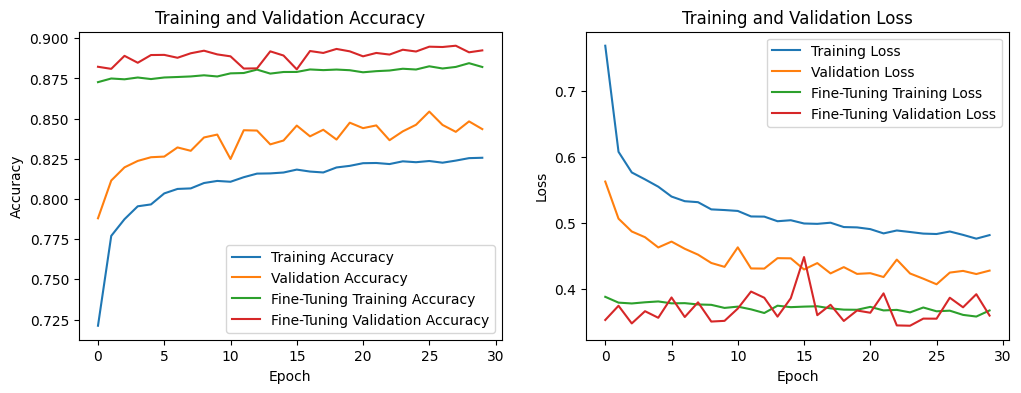

In [29]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.plot(history_fine.history['accuracy'], label='Fine-Tuning Training Accuracy')
plt.plot(history_fine.history['val_accuracy'], label='Fine-Tuning Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.plot(history_fine.history['loss'], label='Fine-Tuning Training Loss')
plt.plot(history_fine.history['val_loss'], label='Fine-Tuning Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.show()